In [1]:
import torch
import torch.nn.functional as F

import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import cv2
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

from fpnssd.albumentations import (
    ToGray, Resize, ToTensor, Normalize, ChannelShuffle,
    CLAHE, Blur, HueSaturationValue, ShiftScaleRotate,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAASharpen, IAAEmboss,
    RandomContrast, RandomBrightness, OneOf, Compose, ToAbsoluteCoords, Rotate, CoordsToBBoxes, BBoxesToCoords
)
from fpnssd.visualization import display_instances

from fpnssd.config import read_config, OPTIMIZERS, LOSSES
from fpnssd.train import PytorchTrain
from fpnssd.dataset import SSDDataset
from fpnssd.utils import set_global_seeds
from fpnssd.models import SSD

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
config = read_config("configs/symbol.yml")
samples = json.load(open("symbol_samples.json"))

In [4]:
model = SSD(
    class2label=config['class2label'],
    bbox_kwargs=config['bbox_kwargs'],
    backbone_kwargs=config['backbone_kwargs'],
    subnet_kwargs=config['subnet_kwargs']
)
model.eval()

SSD(
  (backbone): ResNetFPN(
    (encoder): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
     

In [23]:
from copy import copy
encoder = copy(model.bboxer).encoder
train_transform = Compose([
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.5),
    OneOf([
        MotionBlur(blur_limit=3, p=0.2),
        MedianBlur(blur_limit=3, p=1.0),
        Blur(blur_limit=3, p=0.1),
    ], p=0.5),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
    ], p=0.5),
    RandomContrast(),
    RandomBrightness(),
    HueSaturationValue(p=0.3),
    OneOf([
        ChannelShuffle(),
        ToGray()
    ], p=0.5),
#     Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToAbsoluteCoords(),
    BBoxesToCoords(),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=(-0.3, 0.0), rotate_limit=5, border_mode=cv2.BORDER_CONSTANT),
    CoordsToBBoxes(),
    Resize(min_dim=512, max_dim=512),
#     ToTensor(),
#     encoder
], p=1.0)
test_transform = Compose([
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToAbsoluteCoords(),
    Resize(min_dim=512, max_dim=512),
#     ToTensor(),
#     encoder
], p=1.0)

In [24]:
train_dataset = SSDDataset(class2label=config['class2label'], samples=samples, transform=train_transform)
print(f"Train dataset size: {len(train_dataset)}")

Train dataset size: 5030


In [25]:
hs, ws = [], []
for sample in tqdm_notebook(train_dataset):
    bboxes = sample['bboxes']
    hs.extend((bboxes[:, 2] - bboxes[:, 0]).tolist())
    ws.extend((bboxes[:, 3] - bboxes[:, 1]).tolist())
    
for sample in tqdm_notebook(train_dataset):
    bboxes = sample['bboxes']
    hs.extend((bboxes[:, 2] - bboxes[:, 0]).tolist())
    ws.extend((bboxes[:, 3] - bboxes[:, 1]).tolist())

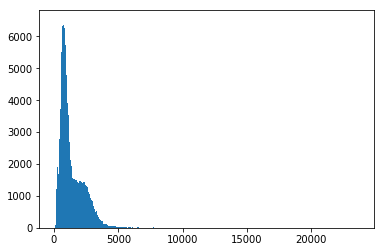

In [28]:
plt.hist(np.array(hs) * np.array(ws), bins=500)
plt.show()

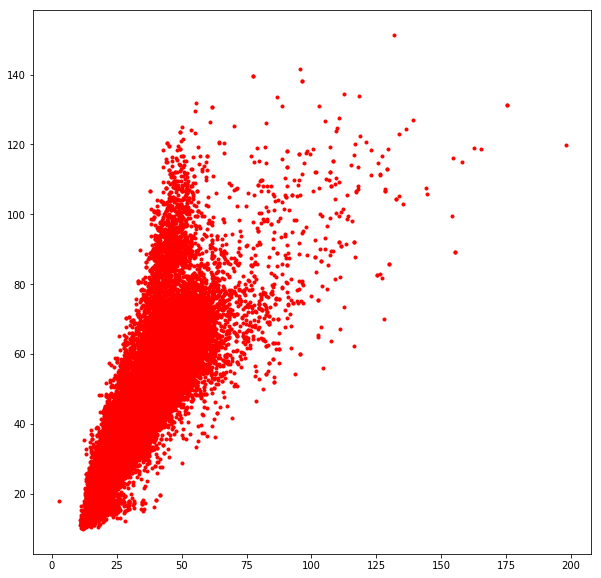

In [27]:
plt.figure(figsize=(10, 10))
plt.plot(hs, ws, 'r.')

In [30]:
model.bboxer.decoder.nms_threshold = 0.1
model.bboxer.decoder.score_threshold = 0.5

In [31]:
bboxes = model.bboxer.decoder(
    bboxes=sample['bboxes'], 
    labels=torch.stack([sample['labels'] - 1, sample['labels']], dim=-1)
)['bboxes']

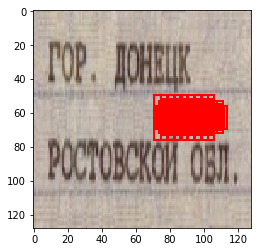

In [55]:
vis_image(sample['image'].permute(1, 2, 0).data.numpy(), model.bboxer.bboxes[4490:4560])

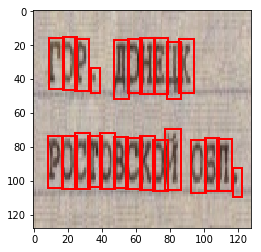

In [33]:
vis_image(sample['image'].permute(1, 2, 0).data.numpy(), bboxes)

In [46]:
sample['bboxes']

array([[ 12.46017699,  50.72031019,  24.69380531,  94.51162791],
       [ 25.1875    ,  49.11627907,  36.52083333,  93.02325581],
       [ 37.40972222,  48.44812084,  47.63194444,  93.58139535],
       [ 48.29861111,  47.69072439,  59.63194444,  94.13953488],
       [ 59.63194444,  47.69072439,  71.63194444,  92.27906977],
       [ 72.29861111,  47.69072439,  82.29861111,  94.88372093],
       [ 82.96527778,  46.88372093,  94.01769912,  93.76744186],
       [ 94.52083333,  46.13953488, 106.29861111,  95.25581395],
       [106.96527778,  44.65116279, 118.03185841,  94.13953488]])

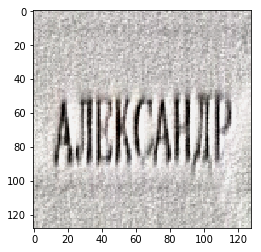

In [45]:
plt.imshow(sample['image'])

In [48]:
import sys

In [54]:
sys.path.append("../transforms/")

In [56]:
!ls ../transforms/

imgs	 pascal_voc.py	test_bounding_boxes.py	test_segmentation_mask.py
LICENSE  README.md	test_keypoints.py	transforms.py


In [41]:
from transforms import (Compose, ColorJitter, BoxesToCoords, RandomRotate,
                        HorizontalFlip, Expand, ObjectRandomCrop, 
                        Resize, CoordsToBoxes, HalfBlood, RandomScale, GridCrop, RandomSizedCrop)

In [56]:
transform = Compose([      
    BoxesToCoords(relative=False),
#     HorizontalFlip(),
#     RandomRotate(angle_range=(-3, 3)),
#     Expand((1, 4), prob=0.5),
#     GridCrop(size=100),
#     RandomScale(size_range=(120, 150)),
    RandomSizedCrop(size=100),
#     ObjectRandomCrop(),
#     Resize(300),
    CoordsToBoxes(relative=False),
    ], 
    mode='linear', 
    border='constant', 
    fillval=0, 
    outside_points='clamp')

In [57]:
transformed_image, transformed_bboxes = transform(sample['image'], sample['bboxes'])

AttributeError: 'tuple' object has no attribute 'shape'

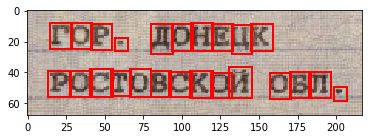

In [58]:
vis_image(sample['image'], sample['bboxes'])

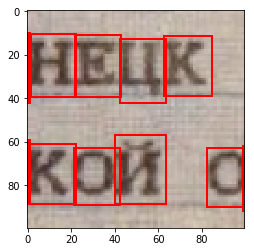

In [55]:
vis_image(transformed_image, transformed_bboxes)

In [158]:
def resize_image(image, min_dim=0, max_dim=256):
    image_dtype = image.dtype
    # Default window (y1, x1, y2, x2) and default scale == 1.
    h, w = image.shape[:2]
    scale=1
    # Scale?
    if min_dim:
        # Scale up but not down
        scale = max(1, min_dim / min(h, w))

    # Does it exceed max dim?
    if max_dim:
        image_max = max(h, w)
        if round(image_max * scale) > max_dim:
            scale = max_dim / image_max

    h, w = image.shape[:2]
    top_pad = (max_dim - h) // 2
    bottom_pad = max_dim - h - top_pad
    left_pad = (max_dim - w) // 2
    right_pad = max_dim - w - left_pad
    padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
    image = np.pad(image, padding, mode='constant', constant_values=0)
    window = (top_pad, left_pad, h + top_pad, w + left_pad)
    return image.astype(image_dtype), window, scale, padding

In [52]:
import sys
import os
import math
import random
import numpy as np
import tensorflow as tf
import scipy
import skimage.color
import skimage.io
import skimage.transform
import urllib.request
import shutil
import warnings


/home/amirassov/.conda/envs/tf36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [159]:
def resize_image(image, bboxes, min_dim=256, max_dim=256, mode='square'):
    image_dtype = image.dtype
    h, w = image.shape[:2]
    scale = max(1, min_dim / min(h, w))

    image_max = max(h, w)
    if round(image_max * scale) > max_dim:
        scale = max_dim / image_max

    if scale != 1:
        image = cv2.resize(image, (round(w * scale), round(h * scale)))

    h, w = image.shape[:2]
    top_pad = (max_dim - h) // 2
    bottom_pad = max_dim - h - top_pad
    left_pad = (max_dim - w) // 2
    right_pad = max_dim - w - left_pad
    padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
    image = np.pad(image, padding, mode='constant', constant_values=0)
    
    bboxes *= scale
    bboxes[:, 0] += left_pad
    bboxes[:, 1] += bottom_pad
    bboxes[:, 2] += right_pad
    bboxes[:, 3] += top_pad
    return image.astype(image_dtype), bboxes

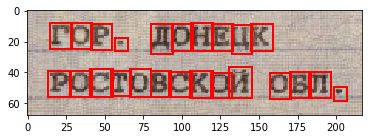

In [160]:
vis_image(sample['image'], sample['bboxes'])

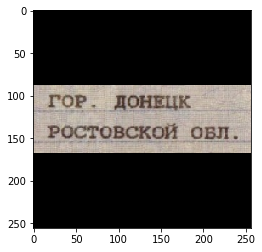

In [164]:
vis_image(*resize_image(sample['image'], bboxes=sample['bboxes']))

In [129]:
cv2.imread(samples[-1501]['filepath']).shape

(74, 331, 3)

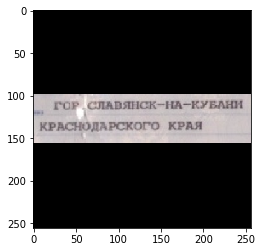

In [130]:
plt.imshow(resize_image(cv2.imread(samples[-1501]['filepath']))[0])